<a href="https://colab.research.google.com/github/juankuntz/ParEM/blob/main/jax/bayesian_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** This notebook demonstrates the application of PGD, PQN, PMGD, and SOUL to the Bayesian logistic regression example in Appendix F.4 of [Scalable particle-based alternatives to EM](https://juankuntz.github.io/publication/parem/) and reproduces Figure 8 and Table 3 therein. 

# Figure 8

First, we load the modules that we will need:

In [1]:
#@title Load modules.

# Install the wget package on Colab (if running the notebook locally,
# comment the following line out).
!pip install wget

# OS and wget to load dataset.
import os
import wget

# Numpy for computations.
import numpy as np

# Pyplot for plots.
import matplotlib.pyplot as plt 

Next, we load and curate the dataset:

In [2]:
#@title Load and normalize the Wisconsin Breast Cancer dataset.

# Fetch dataset from repository:
wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data')

# Load dataset:
dataset = np.loadtxt('breast-cancer-wisconsin.data', dtype=str, delimiter=',')

# Delete local copy of dataset to avoid duplicates with multiple notebook runs:
os.remove('breast-cancer-wisconsin.data')

# Remove datapoints with missing attributes and change dtype to float:
dataset = dataset[~(dataset == '?').any(axis=1), :].astype(float)

# Extract features and labels, and normalize features:
features = np.array(dataset[:, 1:10] - dataset[:, 1:10].mean(0))
features = features/features.std(0)
labels = np.array([(dataset[:, 10]-2)/2]).transpose()

100% [..............................................................................] 19889 / 19889

We then implement the algorithms. They take the following inputs:

*   l : training set labels,
*   f : training set D-dimensional feature vectors,
*   h : step-size,
*   K : number of steps,
*   N : number of particles,
*   th : 1-dimensional vector with parameter guess,
*   X : D x N matrix storing the initial particle cloud.

They return the following outputs:

*   th : K-dimensional vector of parameter estimates,
*   X : D x (KN) matrix storing the particle clouds (the kth cloud is X[:, (k-1)$^\ast$N : k$^\ast$N]).

In [3]:
#@title Implement algorithms.


# Algorithms.

def pgd(l, f, h, K, N, th, X):
    D = f[0, :].size  # Extract latent variable dimension.
    for k in range(K):
        Xk = X[:, -N:]  # Extract current particle cloud.
        #Update particle cloud:
        Xkp1 = (Xk + h*grad_x(th[k], Xk, l, f)
                   + np.sqrt(2*h)*np.random.normal(0, 1, (D, N)))
        X = np.append(X, Xkp1, axis=1) # Store updated cloud.
        th = np.append(th, th[k] + h*ave_grad_th(th[k], Xk))  # Update theta.
    return th, X


def pqn(l, f, h, K, N, th, X):
    D = f[0, :].size  # Extract latent variable dimension.
    for k in range(K):
        Xk = X[:, -N:]  # Extract current particle cloud.
        # Update particle cloud:
        Xkp1 = (Xk + h*grad_x(th[k], Xk, l, f)
                   + np.sqrt(2*h)*np.random.normal(0, 1, (D, N)))
        X = np.append(X, Xkp1, axis=1)  # Store updated cloud.
        # Update theta:
        th = np.append(th, th[k] 
                           + h*(ave_neg_hess_th(D)**-1)*ave_grad_th(th[k], Xk))  
    return th, X


def pmgd(l, f, h, K, N, th, X):
    D = f[0, :].size  # Extract latent variable dimension.
    for k in range(K):
        Xk = X[:, -N:]  # Extract current particle cloud.
        # Update particle cloud:
        Xkp1 = (Xk + h*grad_x(th[k], Xk, l, f)
                   + np.sqrt(2*h)*np.random.normal(0, 1, (D, N)))
        X = np.append(X, Xkp1, axis=1)  # Store updated cloud.
        th = np.append(th, theta_opt(Xkp1))  # Update theta.
    return th, X


def soul(l, f, h, K, N, th, X):
    D = f[0, :].size  # Extract latent variable dimension.
    for k in range(K):
        # Run ULA chain:
        for n in range(N):
            Xkn = X[:, -1].reshape(D, 1)  # Extract current particle position.
            # Take a step:
            Xknp1 = (Xkn + h*grad_x(th[k], Xkn, l, f)
                          + np.sqrt(2*h)*np.random.normal(0, 1, (D, 1)))
            X = np.append(X, Xknp1, axis=1)  # Store new particle position.
        th = np.append(th, th[k] + h*ave_grad_th(th[k], X[:, -N:]))  # Update theta.
    return th, X


# Auxiliary functions.

def ave_grad_th(th, x):
    """Returns theta-gradient of log density averaged over particle cloud."""
    return ((x-th).sum(0)).mean()/5


def ave_neg_hess_th(D):
    """Returns negative-theta-Hessian of log density averaged over particles.
    """
    return D/5


def grad_x(th, x, l, f):
    """Returns x-gradient of log density vectorized over particles."""
    s = 1/(1+np.exp(- np.matmul(f, x)))
    return np.matmul((l-s).transpose(), f).transpose() - (x-th)/5


def theta_opt(X):
    return X.mean()  # Return optimal parameter for particle cloud X.

## Figure 8a

We run the algorithms using an 80/20 training/test split of the data:

In [4]:
# Split data into 80/20 training and testing sets:
from sklearn.model_selection import train_test_split
ftrain, ftest, ltrain, ltest = train_test_split(features, labels, test_size=0.2, 
                                                random_state=0)

# Set approximation parameters:
h = 1e-2 # Step-size. 
K = 400  # Number of steps.
N = 100  # Number of particles.
D = features[0, :].size  # Dimension of latent space.

# Initialize parameter estimates and particle cloud, all at zero:
th0 = np.array([[0]])  # Parameter estimate.
X0 = np.zeros((D, N))  # Particle cloud.

# Run algorithms:
th_pgd, X_pgd = pgd(ltrain, ftrain, h, K, N, th0, X0)
th_pqn, X_pqn = pqn(ltrain, ftrain, h, K, N, th0, X0)
th_pmgd, X_pmgd = pmgd(ltrain, ftrain, h, K, N, th0, X0)
th_soul, X_soul = soul(ltrain, ftrain, h, K, N, th0, X0)

And plot the parameter estimates as a function of k:

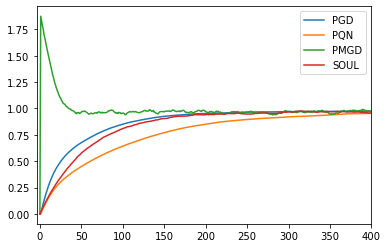

In [5]:
plt.plot(th_pgd, label='PGD') 
plt.plot(th_pqn, label='PQN')
plt.plot(th_pmgd, label='PMGD')
plt.plot(th_soul, label='SOUL')
plt.xlim([-K/100, K])
plt.legend(loc='upper right')

The estimates produced by all four algorithms converge to the same limit after similar transients. To observe more significant differences between the algorithms' outputs, we examine the posterior approximations they return...

## Figure 8b

The posterior approximations produced by SOUL are more peaked than those produced by PGD, PQN, and PMGD:

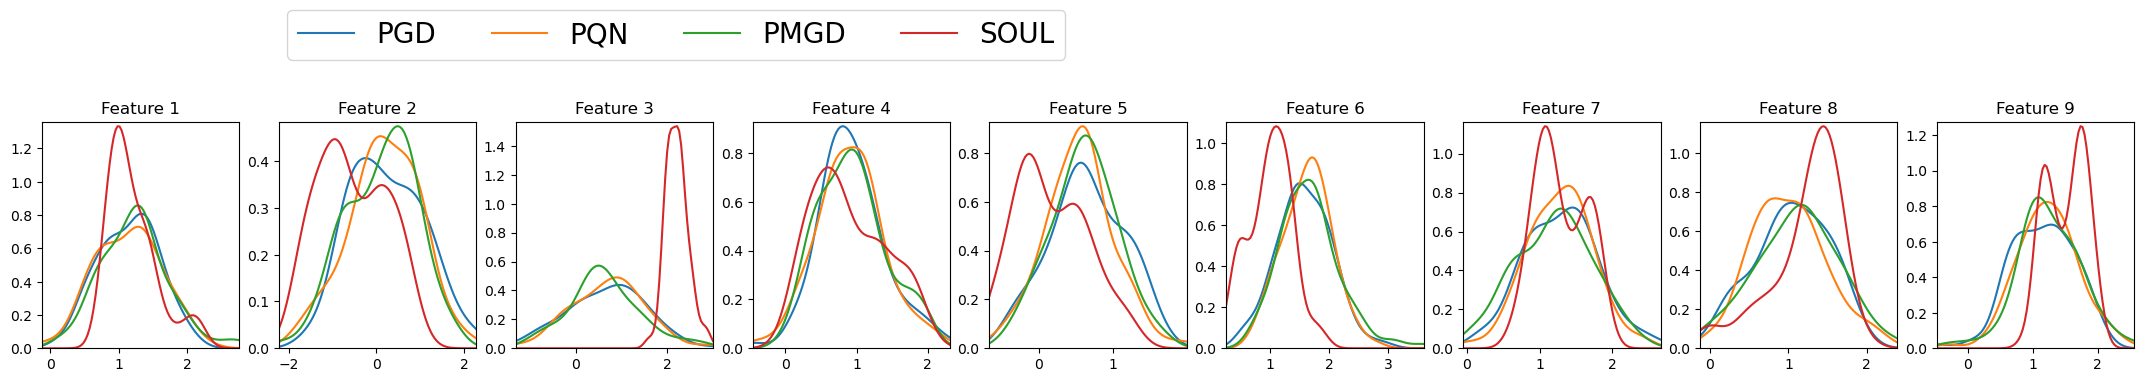

In [6]:
# Extract final particle clouds X^{1:N}_K:
q_pgd = X_pgd[:, -N:]
q_pqn = X_pqn[:, -N:]
q_pmgd = X_pmgd[:, -N:]
q_soul = X_soul[:, -N:]

# Generate and plot KDEs:
from scipy import stats  # stats to generate KDEs.
fig = plt.figure(figsize=(27,3), dpi= 100)
for i in range(D):
    # Generate KDEs for ith entry of the final particle cloud X^{1:N}_K:
    kde_min = np.min([q_pgd[i, :], q_pqn[i, :], q_pmgd[i, :], q_soul[i, :]])
    kde_max = np.max([q_pgd[i, :], q_pqn[i, :], q_pmgd[i, :], q_soul[i, :]])
    xaxis = np.linspace(kde_min, kde_max, num=100)

    kde_pgd = stats.gaussian_kde(q_pgd[i, :])(xaxis)
    kde_pqn = stats.gaussian_kde(q_pqn[i, :])(xaxis)
    kde_pmgd = stats.gaussian_kde(q_pmgd[i, :])(xaxis)
    kde_soul = stats.gaussian_kde(q_soul[i, :])(xaxis)

    # Plot KDEs:
    plt.subplot(1, D, i+1)
    plt.plot(xaxis, kde_pgd, label='PGD')
    plt.plot(xaxis, kde_pqn, label='PQN')
    plt.plot(xaxis, kde_pmgd, label='PMGD')
    plt.plot(xaxis, kde_soul, label='SOUL')
    plt.title('Feature ' + str(i+1))
    plt.ylim([0, 1.02*np.max([kde_pgd, kde_pqn, kde_pmgd, kde_soul])])
    plt.xlim([kde_min, kde_max])
    
    
handles, figlabels = plt.gca().get_legend_handles_labels()
fig.legend(handles, figlabels, ncol=4, bbox_to_anchor=(0.36,1.3), 
           loc="upper center",fontsize=20)
plt.subplots_adjust(hspace=0.6)


## Figure 8c

To spot clear differences between behaviour of the SOUL parameter estimates and that of the PGD, PQN, and PMGD parameter estimates, we initialize the estimates far from the optimal parameter and we initialize the particle cloud far from the corresponding posterior mode:

In [7]:
th0 = np.array([[10]])
X0 = 10*np.ones((D, N))

With this initialization, the PGD, PQN, and PMGD estimates exhibit slower transients than the SOUL estimates:

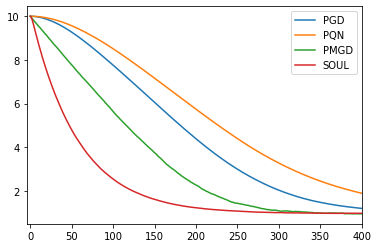

In [8]:
# Re-run algorithms:
th_pgd, X_pgd = pgd(ltrain, ftrain, h, K, N, th0, X0)
th_pqn, X_pqn = pqn(ltrain, ftrain, h, K, N, th0, X0)
th_pmgd, X_pmgd = pmgd(ltrain, ftrain, h, K, N, th0, X0)
th_soul, X_soul = soul(ltrain, ftrain, h, K, N, th0, X0)

# Plot parameter estimates:
plt.plot(th_pgd, label='PGD') 
plt.plot(th_pqn, label='PQN')
plt.plot(th_pmgd, label='PMGD')
plt.plot(th_soul, label='SOUL')
plt.xlim([-K/100, K])
plt.legend(loc='upper right')

However, we can cheaply burn off these long transients using a single-particle run:

In [9]:
# Warm-start using a single-particle run:
th_burn, X_burn = pmgd(ltrain, ftrain, h, K, 1, th0, X0)
th0 = th_burn[-1].reshape((1, 1))
X0 = X_burn[:, -1].reshape((D, 1))*np.ones((1, N))  

# Run the warm-started algorithms:
th_pgd, X_pgd = pgd(ltrain, ftrain, h, K, N, th0, X0)
th_pqn, X_pqn = pqn(ltrain, ftrain, h, K, N, th0, X0)
th_pmgd, X_pmgd = pmgd(ltrain, ftrain, h, K, N, th0, X0)
th_soul, X_soul = soul(ltrain, ftrain, h, K, N, th0, X0)

The estimates produced by all four warm-started algorithms are similar:

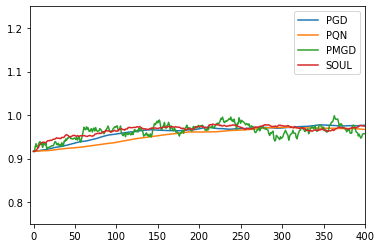

In [10]:
plt.plot(th_pgd, label='PGD') 
plt.plot(th_pqn, label='PQN')
plt.plot(th_pmgd, label='PMGD')
plt.plot(th_soul, label='SOUL')
plt.xlim([-K/100, K])
plt.ylim([0.75, 1.25])
plt.legend(loc='upper right')

# Table 3

We benchmark performance of the algorithms by running them several times. First, we examine their predictive performance, which we evaluate using two metrics: the test error and log pointwise predictive density (see Appendix F.2 for definitions). 

In [11]:
#@title Performance metrics.

def predict(f, X):
    """Returns label maximizing the approximate posterior predictive 
    distribution defined by the cloud X, vectorized over feature vectors f.
    """
    s = 1/(1+np.exp(- np.matmul(f, X))).mean(1)
    out = np.zeros((f[:, 0].size, 1))
    out[s >= 1/2] = 1
    return out


def test_error(f, l, X):
    """Returns fraction of misclassified test points."""
    return (np.abs(l - predict(f, X))).mean()


def lppd(f, l, X):
    """Returns log pointwise predictive density."""
    s = 1/(1+np.exp(- np.matmul(f, X)))
    return np.log((((s ** l) * ((1-s) ** (1-l))).mean(1))).mean()

## Predictive performance

We compute the metrics for M=100 runs.

In [12]:
M = 100  # Number of runs.
N = 100 # Number of particles.
kb = int(K/2)  # Number of burn-in steps.

# Set initial conditions to zero:
th0 = np.array([[0]])  # Parameter estimates.
X0 = np.zeros((D, N))  # Particle cloud.

# Initialize arrays storing the LPPDs and test errors:
lppd_pgd = np.zeros((M))
lppd_pqn = np.zeros((M))
lppd_pmgd = np.zeros((M))
lppd_soul = np.zeros((M))

error_pgd = np.zeros((M))
error_pqn = np.zeros((M))
error_pmgd = np.zeros((M))
error_soul = np.zeros((M))

for m in range(M):
    # Randomize the 80/20 testing/training split of the data:
    ftrain, ftest, ltrain, ltest = train_test_split(features, labels, 
                                                    test_size=0.2, 
                                                    random_state=0)

    # Run the algorithms:
    _, X_pgd = pgd(ltrain, ftrain, h, K, N, th0, X0)
    _, X_pqn = pqn(ltrain, ftrain, h, K, N, th0, X0)
    _, X_pmgd = pmgd(ltrain, ftrain, h, K, N, th0, X0)
    _, X_soul = soul(ltrain, ftrain, h, K, N, th0, X0)

    #Compute LPPDs:
    lppd_pgd[m] = lppd(ftest, ltest, X_pgd[:, N*kb:])
    lppd_pqn[m] = lppd(ftest, ltest, X_pqn[:, N*kb:])
    lppd_pmgd[m] = lppd(ftest, ltest, X_pmgd[:, N*kb:])
    lppd_soul[m] = lppd(ftest, ltest, X_soul[:, N*kb:])

    # Compute test errors:
    error_pgd[m] = test_error(ftest, ltest, X_pgd[:, N*kb:])
    error_pqn[m] = test_error(ftest, ltest, X_pqn[:, N*kb:])
    error_pmgd[m] = test_error(ftest, ltest, X_pmgd[:, N*kb:])
    error_soul[m] = test_error(ftest, ltest, X_soul[:, N*kb:])

#Print statistics (mean +- standard deviation):
print('LPPDs:')
print('PGD: '+str(lppd_pgd.mean())+' \u00B1 '+str(lppd_pgd.std())+'.')
print('PQN: '+str(lppd_pqn.mean())+' \u00B1 '+str(lppd_pqn.std())+'.')
print('PMGD: '+str(lppd_pmgd.mean())+' \u00B1 '+str(lppd_pmgd.std())+'.')
print('SOUL: '+str(lppd_soul.mean())+' \u00B1 '+str(lppd_soul.std())+'.')

print('Test errors:')
print('PGD: '+str(error_pgd.mean())+' \u00B1 '+str(error_pgd.std())+'.')
print('PQN: '+str(error_pqn.mean())+' \u00B1 '+str(error_pqn.std())+'.')
print('PMGD: '+str(error_pmgd.mean())+' \u00B1 '+str(error_pmgd.std())+'.')
print('SOUL: '+str(error_soul.mean())+' \u00B1 '+str(error_soul.std())+'.')

LPPDs:
PGD: -0.09412000732893025 ± 0.00082106277480948.
PQN: -0.09410977037005482 ± 0.0009549864198596631.
PMGD: -0.09385815178710305 ± 0.0008242193923370971.
SOUL: -0.09393810353269796 ± 0.0009871739047938664.
Test errors:
PGD: 0.03445255474452555 ± 0.0034360882615882674.
PQN: 0.0354014598540146 ± 0.0036313410113380288.
PMGD: 0.03510948905109489 ± 0.003214166256394743.
SOUL: 0.034890510948905114 ± 0.0035127618731433468.


## Stationary variance

Next, we compute the stationary variances of the parameter estimates. To ensure that all algorithms reach stationarity, we warm-start them using a single particle run:

In [13]:
# Warm-start using a single-particle run:
th_burn, X_burn = pmgd(ltrain, ftrain, h, K, 1, th0, X0)
th0 = th_burn[-1].reshape((1, 1))
X0 = X_burn[:, -1].reshape((D, 1))*np.ones((1, N))  

# Initialize arrays storing the stationary variances:
var_pgd = np.zeros((M))
var_pqn = np.zeros((M))
var_pmgd = np.zeros((M))
var_soul = np.zeros((M))

for m in range(M):
    # Randomize the 80/20 testing/training split of the data:
    ftrain, ftest, ltrain, ltest = train_test_split(features, labels, 
                                                    test_size=0.2, 
                                                    random_state=0)

    # Run the algorithms:
    th_pgd, _ = pgd(ltrain, ftrain, h, K, N, th0, X0)
    th_pqn, _ = pqn(ltrain, ftrain, h, K, N, th0, X0)
    th_pmgd, _ = pmgd(ltrain, ftrain, h, K, N, th0, X0)
    th_soul, _ = soul(ltrain, ftrain, h, K, N, th0, X0)

    # Compute variances:
    var_pgd[m] = th_pgd[kb:].var()
    var_pqn[m] = th_pqn[kb:].var()
    var_pmgd[m] = th_pmgd[kb:].var()
    var_soul[m] = th_soul[kb:].var()


# Print statistics (mean +- standard deviation):
print('Stationary variances:')
print('PGD: '+str(var_pgd.mean())+' \u00B1 '+str(var_pgd.std())+'.')
print('PQN: '+str(var_pqn.mean())+' \u00B1 '+str(var_pqn.std())+'.')
print('PMGD: '+str(var_pmgd.mean())+' \u00B1 '+str(var_pmgd.std())+'.')
print('SOUL: '+str(var_soul.mean())+' \u00B1 '+str(var_soul.std())+'.')

Stationary variances:
PGD: 1.4630756951207532e-05 ± 1.2340929338098158e-05.
PQN: 8.833357680205068e-06 ± 8.758669866719418e-06.
PMGD: 0.00010785381687329699 ± 3.238802189502859e-05.
SOUL: 2.7616488593870838e-05 ± 1.7922823468870643e-05.


## Runtime

Lastly, we obtain runtime statistics using Python's timeit module (note that Colab can be set to run on a CPU, GPU, or TPU by selecting Runtime --> Change runtime type --> Hardware accelerator):

In [14]:
from timeit import repeat

# Time the algorithms:
t_pgd = np.array(repeat(stmt='pgd(ltrain, ftrain, h, K, N, th0, X0)',
                        number=1, repeat=M, globals=globals()))
t_pqn = np.array(repeat(stmt='pqn(ltrain, ftrain, h, K, N, th0, X0)',
                        number=1, repeat=M, globals=globals()))
t_pmgd = np.array(repeat(stmt='pmgd(ltrain, ftrain, h, K, N, th0, X0)',
                         number=1, repeat=M, globals=globals()))
t_soul = np.array(repeat(stmt='soul(ltrain, ftrain, h, K, N, th0, X0)',
                         number=1, repeat=M, globals=globals()))

# Print statistics (mean +- standard deviation):
print('Runtimes:')
print('PGD: '+str(t_pgd.mean())+' \u00B1 '+str(t_pgd.std())+'.')
print('PQN: '+str(t_pqn.mean())+' \u00B1 '+str(t_pqn.std())+'.')
print('PMGD: '+str(t_pmgd.mean())+' \u00B1 '+str(t_pmgd.std())+'.')
print('SOUL: '+str(t_soul.mean())+' \u00B1 '+str(t_soul.std())+'.')

Runtimes:
PGD: 0.7667224009998609 ± 0.1672231151519011.
PQN: 0.935774363000055 ± 0.17756554957269507.
PMGD: 1.0037883770000553 ± 0.347728932388705.
SOUL: 3.7915689570000906 ± 0.21967908667263344.
